In [1]:
import os
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sys
sys.path.append('/tmp/local_scratch/v_neelesh_bisht/3d-cnn/')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from config import ResnetConfig
from models import Resnet3D
from dataset import TrainTestDataset
from utils import CommonUtils, Device
from train import Train
from validate import Validate
from inference import Inference

In [2]:
config = ResnetConfig()

# get device for processing
device_obj = Device()
device_obj.set_device(config.gpu_id[0])
device = device_obj.get_device()
print(f"Using device: {device}")

seed = config.manual_seed

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



Using device: cuda:3


In [3]:
train_dataset = TrainTestDataset()

# Create datasets
validation_dataset = train_dataset.validation_dataset
train_loader = train_dataset.train_loader
validation_loader = train_dataset.validation_loader
test_loader = train_dataset.test_loader

for inputs, labels in train_loader:
    print(inputs.shape)
    break

CT scans with normal lung tissue: 254
CT scans with abnormal lung tissue: 254
Number of samples in train, validation and test are 406 , 76 and 26.
torch.Size([4, 1, 64, 128, 128])


<class 'torch.Tensor'>
Dimensions of the CT scan are: (1, 64, 128, 128)


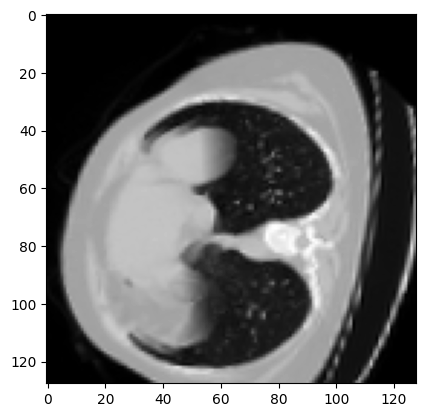

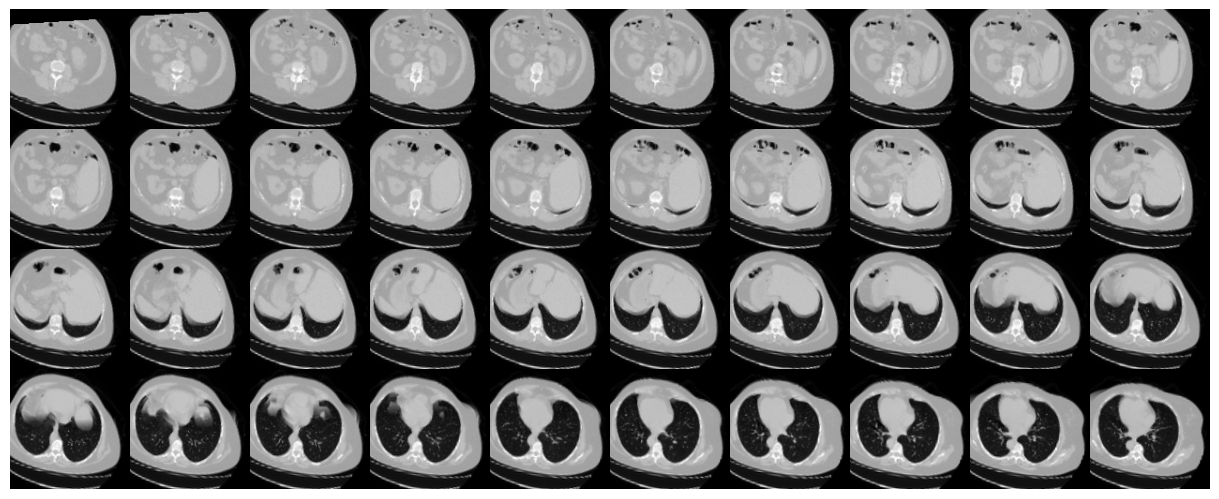

In [4]:
# Get a single batch from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Convert the images to numpy arrays
print(type(images))
images = images.numpy()
image = images[0]

print('Dimensions of the CT scan are:', image.shape)

# Visualize a slice from the 3D CT scan
plt.imshow(np.squeeze(image[0, 30, :, :, ]), cmap='gray')
plt.show()

# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
image = image[0] # (64, 128, 128) (depth, width, height)
t_image = np.transpose(image, (2, 1, 0)) # (128, 128, 64) (width, height, depth)
CommonUtils.plot_slices(4, 10, 128, 128, t_image[:, : ,:40]) # (128, 128, 40) (width, height, depth)

In [5]:
model, parameters = Resnet3D.generate_model(config) 
print (model)

/local/scratch/v_neelesh_bisht/3d-cnn/models/resnet/model/renset_all.py:51: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


loading pretrained model models/archive/tecent_med3d_pretrain/resnet_34_23dataset.pth
DataParallel(
  (module): ResNet(
    (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 

In [6]:
params = [
    { 'params': parameters['base_parameters'], 'lr': config.learning_rate }, 
    { 'params': parameters['new_parameters'], 'lr': config.learning_rate*100 }
    ]

In [7]:
# Define loss function and optimizer

criterion = nn.CrossEntropyLoss()  # Binary Cross Entropy Loss for binary classification
criterion = criterion.to(device)
optimizer = torch.optim.SGD(params, momentum=0.9, weight_decay=config.weight_decay)  

# Learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)


best_val_loss = float('inf')
prev_val_acc = 0

history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}


# Main training loop
for epoch in range(config.epochs):
    # Update learning rate
    scheduler.step()
    
    train_loss, train_acc = Train.train(model, train_loader, optimizer, criterion, epoch , device)
    val_loss, val_acc = Validate.validate(model, validation_loader, criterion, device)
    
    print(f'Epoch {epoch+1}/{config.epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Save the model if validation loss decreases
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), config.model_path)
    
    # After training loop, append the performance metrics to history for visualization
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    # Early stopping
    if epoch > config.max_epochs and val_acc < prev_val_acc: 
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    prev_val_acc = val_acc


/shared/home/v_neelesh_bisht/local_scratch/cmu_research/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/300, Train Loss: 2.7543, Train Acc: 0.4926, Val Loss: 3.1064, Val Acc: 0.5000
Epoch 2/300, Train Loss: 2.5539, Train Acc: 0.5123, Val Loss: 2.1761, Val Acc: 0.5263
Epoch 3/300, Train Loss: 2.1413, Train Acc: 0.5369, Val Loss: 2.2489, Val Acc: 0.5000
Epoch 4/300, Train Loss: 1.6988, Train Acc: 0.5320, Val Loss: 2.1456, Val Acc: 0.5132
Epoch 5/300, Train Loss: 1.4415, Train Acc: 0.5591, Val Loss: 1.5244, Val Acc: 0.5789
Epoch 6/300, Train Loss: 1.7728, Train Acc: 0.5197, Val Loss: 0.9180, Val Acc: 0.6184
Epoch 7/300, Train Loss: 2.1380, Train Acc: 0.5123, Val Loss: 3.3429, Val Acc: 0.5000
Epoch 8/300, Train Loss: 1.7944, Train Acc: 0.5369, Val Loss: 1.2648, Val Acc: 0.6184
Epoch 9/300, Train Loss: 1.5778, Train Acc: 0.5222, Val Loss: 1.1321, Val Acc: 0.6053
Epoch 10/300, Train Loss: 1.4261, Train Acc: 0.5345, Val Loss: 1.5191, Val Acc: 0.5263
Epoch 11/300, Train Loss: 1.1796, Train Acc: 0.5443, Val Loss: 1.3644, Val Acc: 0.5263
Epoch 12/300, Train Loss: 1.1164, Train Acc: 0.6108,

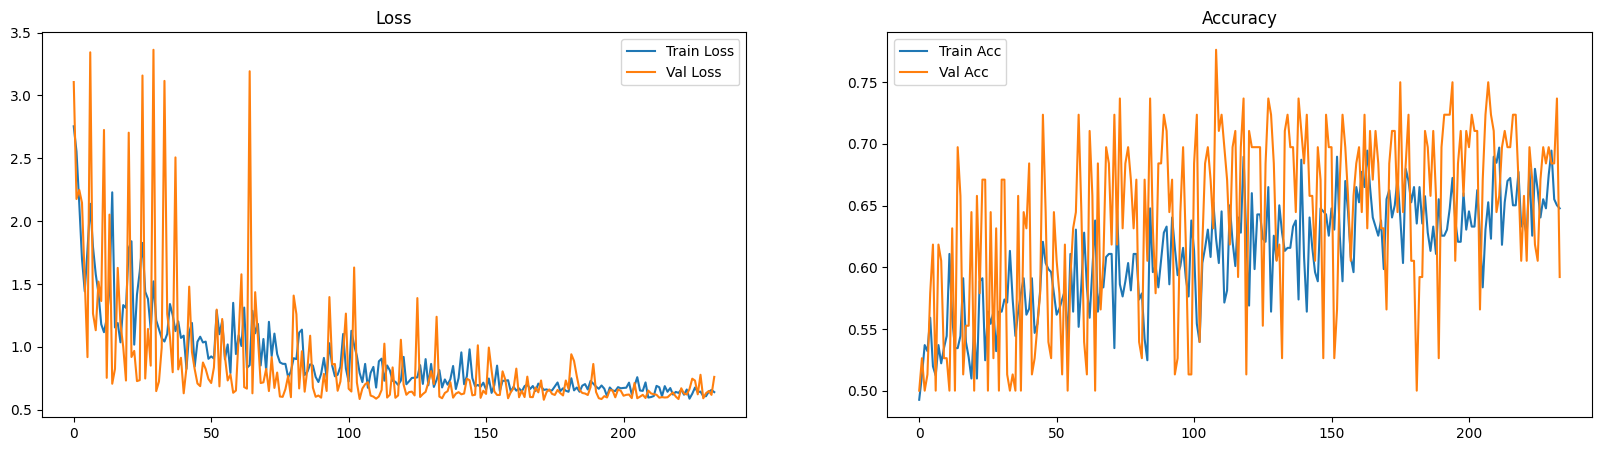

In [8]:
CommonUtils.plot_accuracy_loss_graphs(history['train_loss'], history['val_loss'], history['train_acc'], history['val_acc'])

In [9]:
model.load_state_dict(torch.load(config.model_path))
model.eval()

# For testing
test_acc = Inference.inference(model, test_loader, device)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.6538
